In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime

import torch

In [2]:
# load in all 5 csv's

confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('time_series_covid19_recovered_global.csv')
latest_data_df = pd.read_csv('07-12-2020.csv')
csse_daily_df = pd.read_csv('csse_daily.csv')

In [3]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,15500,15941,16404,16879,17348,17808,18242,18712,19195,19689
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,858
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,346,346,346,386,386,396,458,462,506,525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,...,719,720,721,724,724,726,727,727,729,732
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1248,1265,1284,1297,1318,1356,1380,1389,1465,1498
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,309,311,311,311,313,314,314,317,317,317
264,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,6159,6213,6262,6315,6364,6410,6457,6506,6552,6596


**Recovery df has some missing rows**

In [4]:
recoveries_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,19164,19366,20103,20179,20700,20847,20882,21135,21216,21254
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1637,1657,1702,1744,1791,1832,1875,1881,1946,2014
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,11181,11492,11884,12094,12329,12637,13124,13124,13743,14019
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,800,800,800,800,802,802,803,803,803,803
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,108,108,108,117,117,117,117,118,118,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,...,267,268,269,279,283,283,284,284,286,286
249,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,537,552,575,591,595,619,630,642,659,675
250,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,241,266,266,266,272,272,272,296,296,296
251,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,4809,4858,4914,4965,5011,5067,5115,5176,5228,5278


### Let's do a sanity check on the dates and see if all have same dates

In [5]:
all(confirmed_df.keys()[4:]==deaths_df.keys()[4:])

True

In [6]:
all(deaths_df.keys()[4:]==recoveries_df.keys()[4:])

True

In [7]:
csse_daily_df

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,2020-07-13 04:43:04,34.223334,-82.461707,153,1,0,152.0,"Abbeville, South Carolina, US",623.802340,0.653595
1,22001.0,Acadia,Louisiana,US,2020-07-13 04:43:04,30.295065,-92.414197,1339,45,0,1294.0,"Acadia, Louisiana, US",2158.111048,3.360717
2,51001.0,Accomack,Virginia,US,2020-07-13 04:43:04,37.767072,-75.632346,1042,14,0,1028.0,"Accomack, Virginia, US",3224.408962,1.343570
3,16001.0,Ada,Idaho,US,2020-07-13 04:43:04,43.452658,-116.241552,4146,25,0,4121.0,"Ada, Idaho, US",860.903637,0.602991
4,19001.0,Adair,Iowa,US,2020-07-13 04:43:04,41.330756,-94.471059,17,0,0,17.0,"Adair, Iowa, US",237.695749,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,NaN,NaN,NaN,Yemen,2020-07-13 04:43:04,15.552727,48.516388,1465,417,659,389.0,Yemen,4.911827,28.464164
3809,NaN,NaN,NaN,Zambia,2020-07-13 04:43:04,-13.133897,27.849332,1895,42,1412,441.0,Zambia,10.307901,2.216359
3810,NaN,NaN,NaN,Zimbabwe,2020-07-13 04:43:04,-19.015438,29.154857,985,18,328,639.0,Zimbabwe,6.627228,1.827411
3811,16061.0,Lewis,Idaho,US,2020-07-10 02:34:22,46.233153,-116.434146,1,0,0,1.0,"Lewis, Idaho, US",26.055237,0.000000


## Let's have a brief look at csse daily data

In [8]:
csse_daily_df['Country_Region'].value_counts()

US            3142
Russia          83
Japan           48
India           36
Colombia        34
              ... 
Croatia          1
Guyana           1
Guinea           1
Tajikistan       1
Uzbekistan       1
Name: Country_Region, Length: 188, dtype: int64

## Number of samples per country in our data

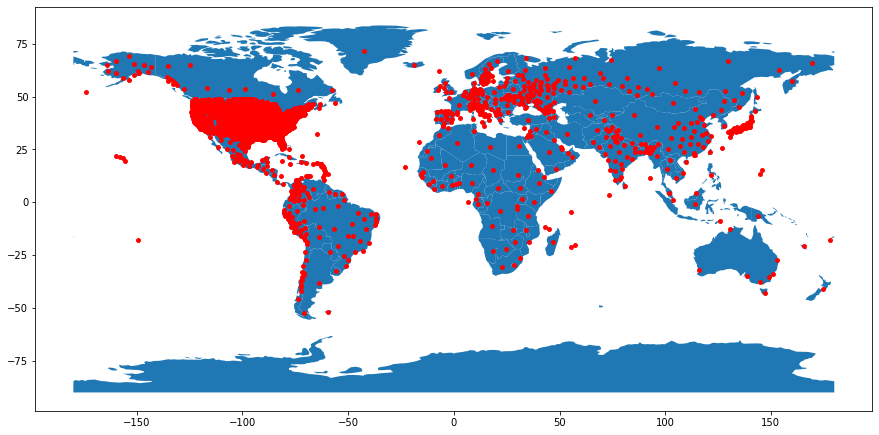

In [9]:
# let's look at the csse daily data
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(csse_daily_df['Long_'], csse_daily_df['Lat'])]
gdf = GeoDataFrame(csse_daily_df[['Lat','Long_']], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='red', markersize=15);

**This shows us how the virus is spread out through out the world acc to given data. Seems like Data is skewed towards US more**

In [10]:
# Top 7 countries
csse_daily_df['Country_Region'].value_counts()[:7]
# US has over 3000 entries in data

US          3142
Russia        83
Japan         48
India         36
Colombia      34
China         33
Mexico        32
Name: Country_Region, dtype: int64

## Total cases country wise

In [11]:
top_c = csse_daily_df.groupby(['Country_Region']).Confirmed.sum().sort_values(ascending=False)
top_c

Country_Region
US                       3304942
Brazil                   1864681
India                     878254
Russia                    726036
Peru                      326326
                          ...   
Saint Kitts and Nevis         17
Holy See                      12
Papua New Guinea              11
Western Sahara                10
MS Zaandam                     9
Name: Confirmed, Length: 188, dtype: int64

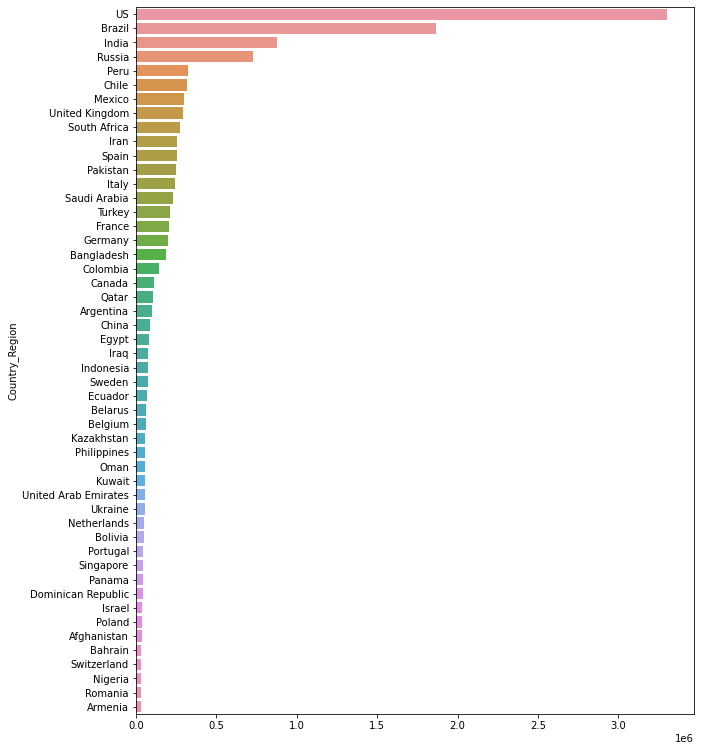

In [12]:
# Top 50 Country wise Confirmed cases acc to given data

fig, ax = plt.subplots(figsize=(10, 13))
sns.barplot(y=top_c.index[:50], x=top_c.values[:50])

## It looks like most of the data is very much skewed towards US, with 3000+ entries

*So, let's focus on US only and see what columns have significance in the result or what are the correlations, to see whether we should do time series prediction only or should also look at other variables to consider.*

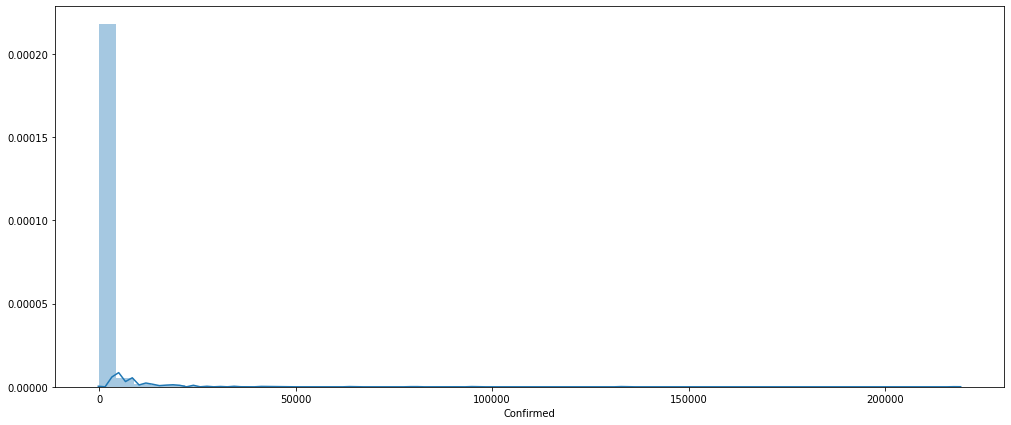

In [13]:
csse_daily_df_us = csse_daily_df[csse_daily_df['Country_Region']=='US'] # get US only data

fig, ax = plt.subplots(figsize=(17, 7))
sns.distplot(csse_daily_df_us['Confirmed'].dropna())

In [14]:
# Drop Unnecessary Columns
csse_daily_df_us.drop(['Country_Region','Province_State','Long_','Last_Update','Combined_Key'], axis=1, inplace=True)

csse_daily_df_us.Recovered.value_counts()

C:\Users\wwech\Anaconda3\envs\env_pytorch\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0          3141
1006326       1
Name: Recovered, dtype: int64

In [15]:
# since recovered has only 1 statis value, we will simply drop it too

csse_daily_df_us.drop(['Recovered'], axis=1, inplace=True)

In [16]:
csse_daily_df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3812
Data columns (total 8 columns):
FIPS                   3131 non-null float64
Admin2                 3135 non-null object
Lat                    3081 non-null float64
Confirmed              3142 non-null int64
Deaths                 3142 non-null int64
Active                 3140 non-null float64
Incidence_Rate         3081 non-null float64
Case-Fatality_Ratio    3096 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 220.9+ KB


In [17]:
print("{} \nNan values found".format(csse_daily_df_us.isna().sum()))
csse_daily_df_us.dropna(inplace=True) # drop na

FIPS                   11
Admin2                  7
Lat                    61
Confirmed               0
Deaths                  0
Active                  2
Incidence_Rate         61
Case-Fatality_Ratio    46
dtype: int64 
Nan values found


C:\Users\wwech\Anaconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Testing of Columns Relationships**

1.) Plot the heatmap of correlation

2.) get pearson correlation and drop columns with certain values

3.) Do a chi2 test to get the significance level if necessary

4.) Do a z-value or IQR test to see outliers if necessary

## We can study relationship between pairs of columns and deduce the relationship and significance of Variables

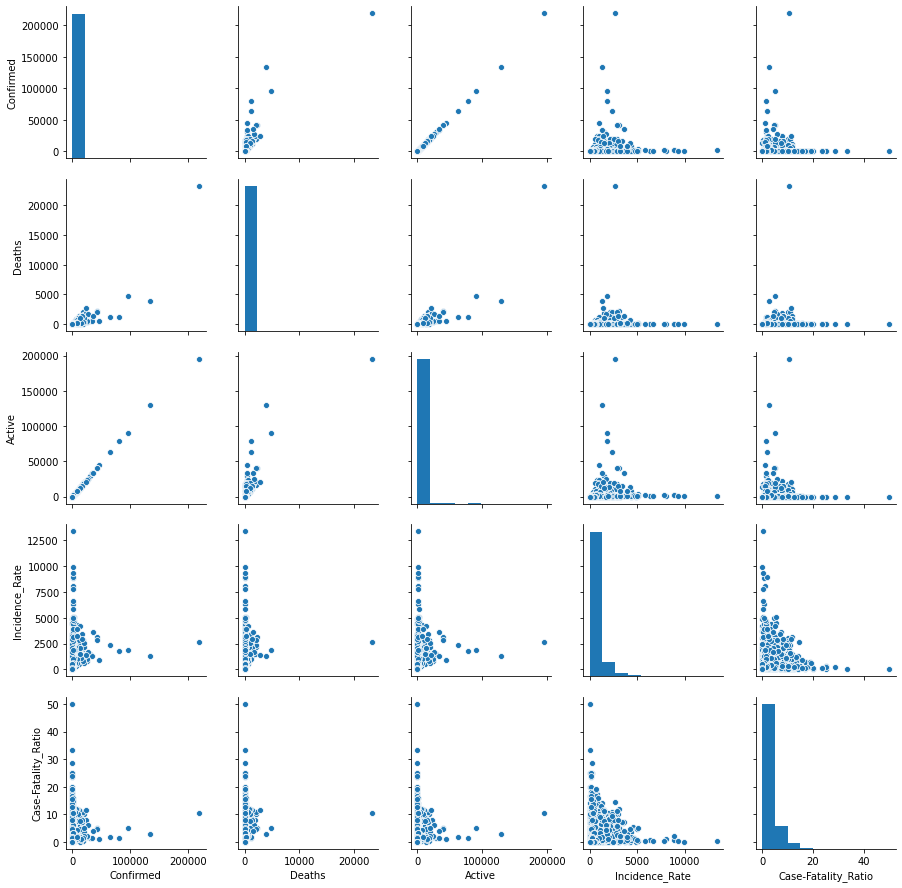

In [18]:
sns.pairplot(csse_daily_df_us[['Confirmed','Deaths','Active','Incidence_Rate','Case-Fatality_Ratio']])

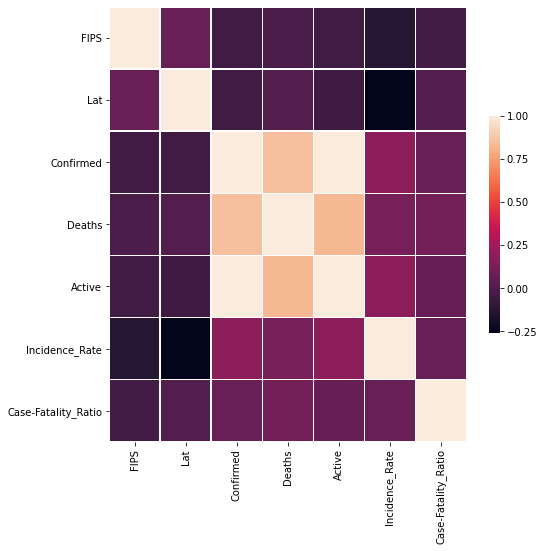

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
corr = csse_daily_df_us.corr()
sns.heatmap(corr, linewidths=.5, cbar_kws={"shrink": .5})

**Confirm, death, and Active have high positive corelation, where as rest has negative corelation**

### We should find pearson correlation to better understand how much the correlation is and what we want to keep, or should we spend time on this data

In [20]:
# Label Encode Admin2 columns

from sklearn.preprocessing import LabelEncoder

admin2 = LabelEncoder()

csse_daily_df_us['Admin2'] = admin2.fit_transform(csse_daily_df_us['Admin2'])
csse_daily_df_us

C:\Users\wwech\Anaconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,FIPS,Admin2,Lat,Confirmed,Deaths,Active,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,0,34.223334,153,1,152.0,623.802340,0.653595
1,22001.0,1,30.295065,1339,45,1294.0,2158.111048,3.360717
2,51001.0,2,37.767072,1042,14,1028.0,3224.408962,1.343570
3,16001.0,3,43.452658,4146,25,4121.0,860.903637,0.602991
4,19001.0,4,41.330756,17,0,17.0,237.695749,0.000000
...,...,...,...,...,...,...,...,...
3129,8125.0,1785,40.003468,54,0,54.0,538.975946,0.000000
3130,48505.0,1786,27.001564,76,0,76.0,536.003950,0.000000
3131,48507.0,1787,28.866172,60,0,60.0,506.756757,0.000000
3132,46137.0,1788,44.978819,3,0,3.0,108.853411,0.000000


#### pearsonr= if it is 1, there is positive correlation and if it is, -1 there is negative correlation.
#### If it is zero, there is no correlation between variables

In [21]:
from scipy.stats import pearsonr

should_drop = []
for idx,i in enumerate(['FIPS', 'Admin2', 'Lat', 'Active','Incidence_Rate', 'Case-Fatality_Ratio']):
    for j in ['Confirmed','Deaths']: # go through columns and find corr
        corr, _ = pearsonr(csse_daily_df_us[i],csse_daily_df_us[j]) # use scipy
        print(i,"has corr value =",corr,"with",j)
        if corr > 0.85: 
            should_drop.append(i)
#             csse_daily_df_us.drop(j,axis=1,inplace = True) # drop it
            
    
should_drop

FIPS has corr value = -0.04188686321576434 with Confirmed
FIPS has corr value = -0.012301110993034168 with Deaths
Admin2 has corr value = 0.015977547593814277 with Confirmed
Admin2 has corr value = 0.012916554984648412 with Deaths
Lat has corr value = -0.0448746385216212 with Confirmed
Lat has corr value = 0.014645931396982018 with Deaths
Active has corr value = 0.999102247999305 with Confirmed
Active has corr value = 0.8327122431123077 with Deaths
Incidence_Rate has corr value = 0.1836466910881568 with Confirmed
Incidence_Rate has corr value = 0.11953717377291528 with Deaths
Case-Fatality_Ratio has corr value = 0.07855059127864542 with Confirmed
Case-Fatality_Ratio has corr value = 0.11284483189050307 with Deaths


['Active']

**Active has very high corr value, which is obvious but rest actually have corr value very close to 0, i.e 0.01,0.04 and values like these are never good to use in modelling, and will yield for lower p-values. 
We can remove them and will be left with "Incidence_Rate"**

Let's do a **chi sq test** and find sifnificance if we have any, I am not yet normalizing the data tho. 

[*We can use p-value test as well to get significance, if any*]

In [22]:
# LEt's keep Confirmed a target variable
X_conf = csse_daily_df_us.drop(['Confirmed'],axis=1)
y_conf = csse_daily_df_us['Confirmed']

from sklearn.feature_selection import SelectKBest, chi2

best_feature = SelectKBest(score_func= chi2, k = 'all')
best_feature = best_feature.fit(X_conf,y_conf)

col_scores = pd.DataFrame(best_feature .scores_)
col_names = pd.DataFrame(X_conf.columns)

feature_score = pd.concat([col_names, col_scores], axis=1)
feature_score.columns = ['attribute', 'score']
feature_score

,attribute,score
0,FIPS,8.955269e+06
1,Admin2,3.120015e+05
2,Lat,8.677451e+02
3,Deaths,1.483012e+07
4,Active,9.443298e+07
5,Incidence_Rate,2.532063e+06
6,Case-Fatality_Ratio,4.236607e+03


### A very large chi square test statistic means that the data does not fit very well. In other words, there isn't a relationship.
Here we have very high values, which doesn't seem like any variable is good to predict Confirmed case. Let's first look at time series data and see what we can dig out

# Let's look at time series data

In [23]:
# get a list of dates 
dates = confirmed_df.keys()[4:]

confirmed = confirmed_df.loc[:, dates]
deaths = deaths_df.loc[:, dates]
recoveries = recoveries_df.loc[:, dates]

confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,0,0,0,0,0,0,0,0,0,0,...,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455
1,0,0,0,0,0,0,0,0,0,0,...,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571
2,0,0,0,0,0,0,0,0,0,0,...,15500,15941,16404,16879,17348,17808,18242,18712,19195,19689
3,0,0,0,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,858
4,0,0,0,0,0,0,0,0,0,0,...,346,346,346,386,386,396,458,462,506,525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0,0,0,0,0,0,0,0,0,0,...,719,720,721,724,724,726,727,727,729,732
262,0,0,0,0,0,0,0,0,0,0,...,1248,1265,1284,1297,1318,1356,1380,1389,1465,1498
263,0,0,0,0,0,0,0,0,0,0,...,309,311,311,311,313,314,314,317,317,317
264,0,0,0,0,0,0,0,0,0,0,...,6159,6213,6262,6315,6364,6410,6457,6506,6552,6596


In [24]:
total_cases = confirmed.sum(axis=0).values
total_deaths = deaths.sum(axis=0).values
total_recoveries = recoveries.sum(axis=0).values

# let's find how many are active still, those who didn't die or recovered but were daignozed
total_active = total_cases - total_deaths - total_recoveries

In [25]:
print("total cases accumulated = {} \noverall total_cases = {}".format(max(total_cases),max(confirmed['7/13/20'])))

total cases accumulated = 13104391 
overall total_cases = 3364157


## With this we can see that data is accumulated over dates, which means it is not showing us new cases of every day, but accumulative cases till date. 

## We will need to find daily average of the cases to get a better idea

In [26]:
# get the unique countries
countries = confirmed_df['Country/Region'].unique()
len(countries)

188

## Worst affected counutries till date, take top 50 worst

In [27]:
def p(x):
    return x.loc[:,dates].sum(axis=1).values[0]

worst_countries = confirmed_df.groupby('Country/Region').apply(p).sort_values(ascending = False)[:50]
worst_countries[:10]

Country/Region
US         170145797
Brazil      59007033
Russia      34507842
India       24225853
Spain       23691881
Italy       23318338
Germany     18207271
Iran        15450022
Turkey      14809049
Peru        14227071
dtype: int64

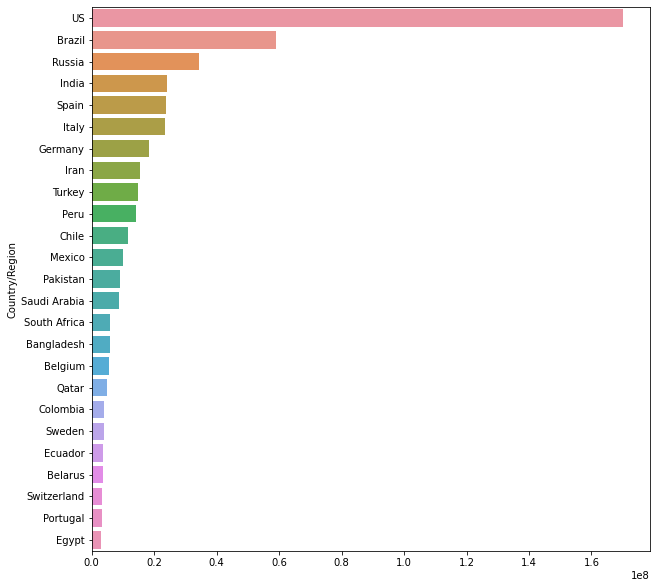

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y=worst_countries.index[:25], x=worst_countries.values[:25])

In [29]:
# This method is imp because we have data in accumulative format
def daily_values(data):
    d = [] 
    d.append(data[0])
    for i in range(1,len(data)):
        d.append(data[i]-data[i-1]) # get unique date for the day, since it is accumulative
    return d 

def weekly_average(data):
    weekly_average = []
    for i in range(len(data)):
        if i + 7 < len(data):
            weekly_average.append(np.mean(data[i:i+7]))
        else:
            weekly_average.append(np.mean(data[i:len(data)]))
    return weekly_average


# mortality rate
mortality_rate = np.array(daily_values(total_deaths))/np.array(daily_values(total_cases))

#recovery rate
recovery_rate = np.array(daily_values(total_recoveries))/np.array(daily_values(total_cases))

In [30]:
#days array
days = np.array(range(len(dates))).reshape(-1, 1)

# confirmed cases
global_daily_values = daily_values(total_cases)
global_daily_increase_avg = weekly_average(global_daily_values)

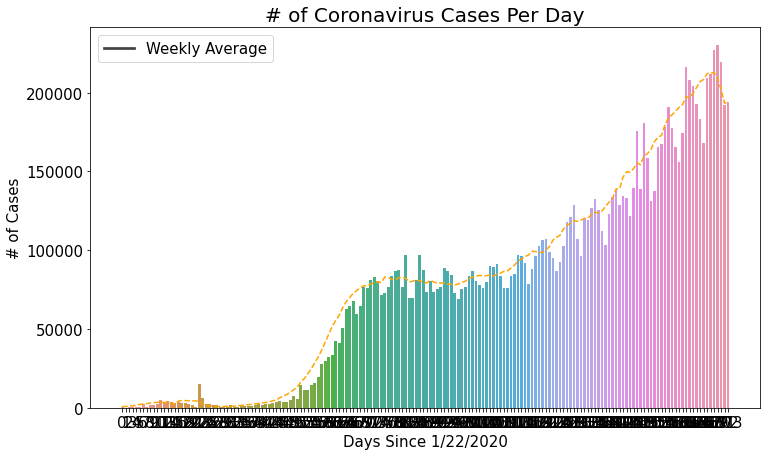

In [31]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(x = list(range(len(global_daily_values))),y = global_daily_values)
plt.plot(days, global_daily_increase_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Per Day', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()


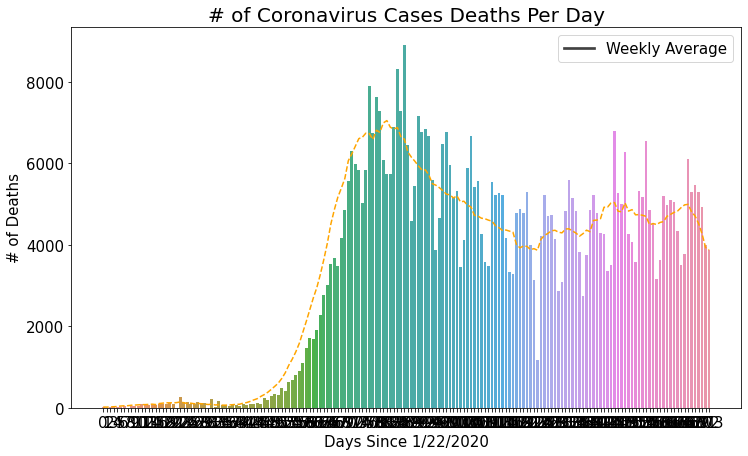

In [32]:
# Daily Deaths
global_daily_deaths = daily_values(total_deaths)
global_daily_death_avg = weekly_average(global_daily_deaths)

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = list(range(len(global_daily_deaths))),y=global_daily_deaths)
plt.plot(days, global_daily_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Deaths Per Day', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Deaths', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

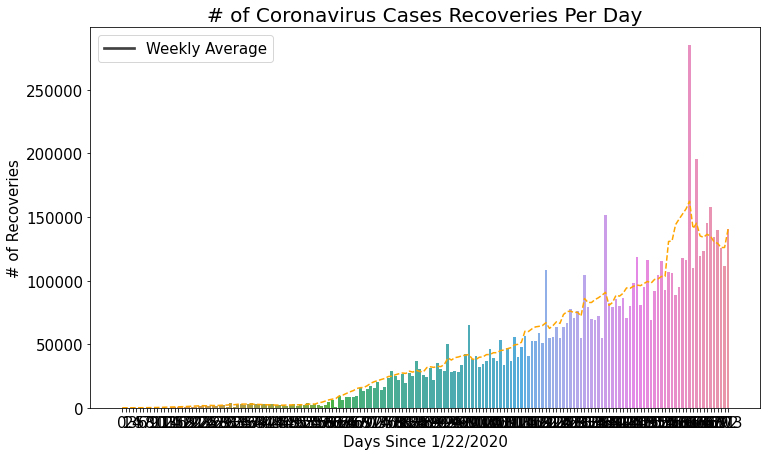

In [33]:
# Daily Recoveries
global_daily_recoveries = daily_values(total_recoveries)
global_daily_recoveries_avg = weekly_average(global_daily_recoveries)


fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = list(range(len(global_daily_recoveries))),y=global_daily_recoveries)
plt.plot(days, global_daily_recoveries_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Recoveries Per Day', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Recoveries', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

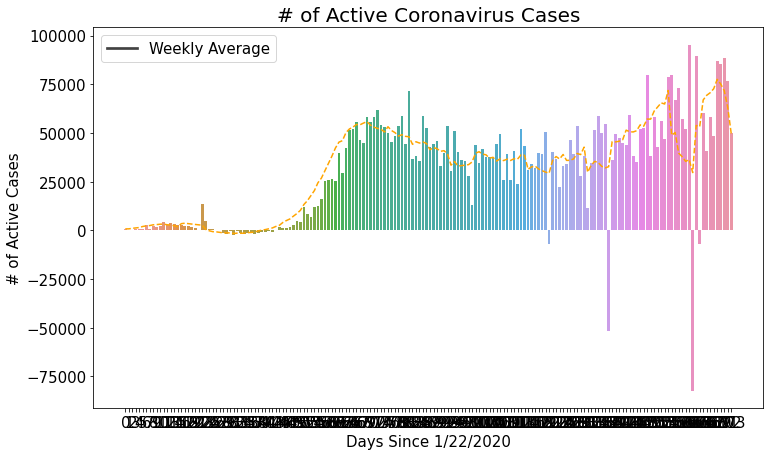

In [34]:
#Active Cases
global_daily_active = daily_values(total_active)
global_active_avg = weekly_average(global_daily_active)


fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = list(range(len(global_daily_active))),y=global_daily_active)
plt.plot(days, global_active_avg, linestyle='dashed', color='orange')
plt.title('# of Active Coronavirus Cases', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Active Cases', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### Some values in Recoveries data shows -ve recoveries. This is the inconsostency and Outliers in Data which needs to be fixed. There are 4 faulty values.

### Let's get Log Values

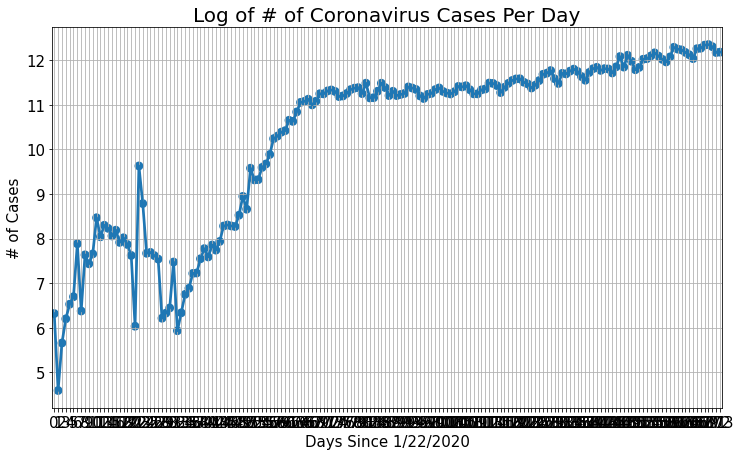

In [35]:
plt.figure(figsize=(12, 7))
sns.pointplot(x = days[:,0] , y = np.log(global_daily_values))
plt.title('Log of # of Coronavirus Cases Per Day', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

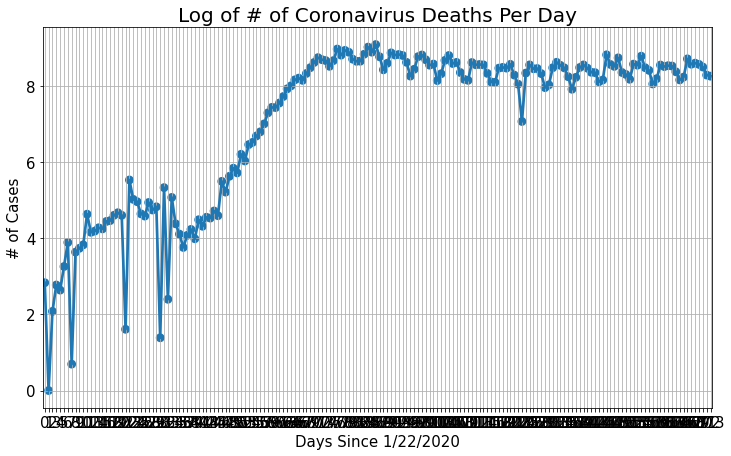

In [36]:
plt.figure(figsize=(12, 7))
sns.pointplot(x = days[:,0] , y = np.log(global_daily_deaths))
plt.title('Log of # of Coronavirus Deaths Per Day', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

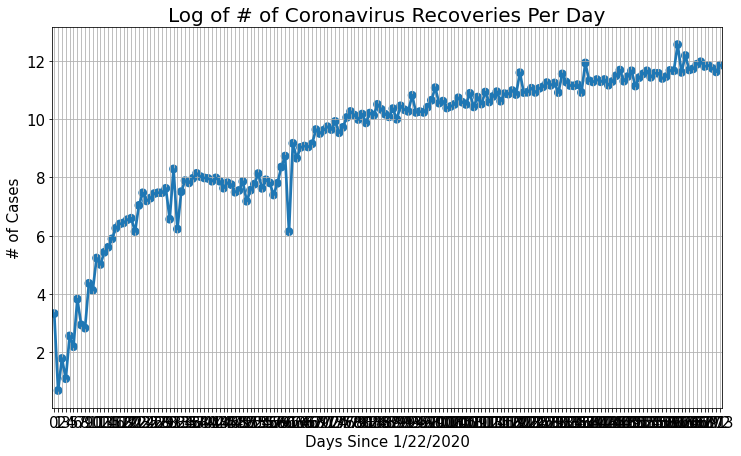

In [37]:
plt.figure(figsize=(12, 7))
sns.pointplot(x = days[:,0] , y = np.log(global_daily_recoveries))
plt.title('Log of # of Coronavirus Recoveries Per Day', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

## Let's look at the Recovery and mortality rate 

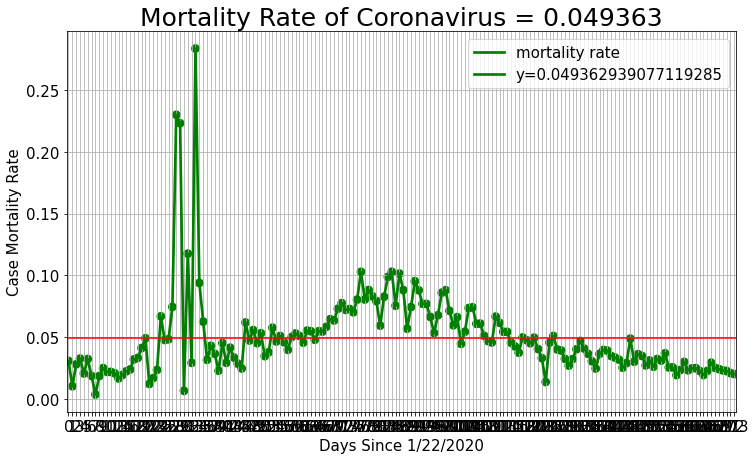

In [38]:
plt.figure(figsize=(12, 7))

sns.pointplot(days[:,0], mortality_rate, color='Green')
plt.axhline(y = np.mean(mortality_rate),linestyle='-', color='red')
plt.title('Mortality Rate of Coronavirus = {0:2f}'.format(np.mean(mortality_rate)), size=25)
plt.legend(['mortality rate', 'y='+str(np.mean(mortality_rate))], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Case Mortality Rate', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

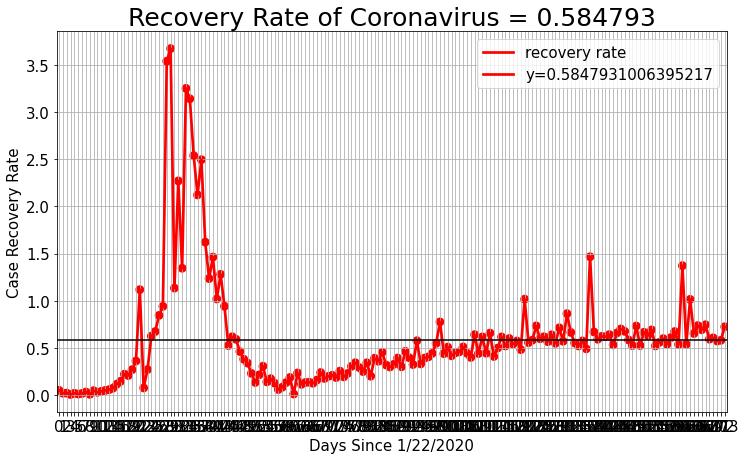

In [39]:
plt.figure(figsize=(12, 7))

sns.pointplot(days[:,0], recovery_rate, color='red')
plt.axhline(y = np.mean(recovery_rate),linestyle='-', color='black')
plt.title('Recovery Rate of Coronavirus = {0:2f}'.format(np.mean(recovery_rate)), size=25)
plt.legend(['recovery rate', 'y='+str(np.mean(recovery_rate))], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Case Recovery Rate', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

C:\Users\wwech\Anaconda3\envs\env_pytorch\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


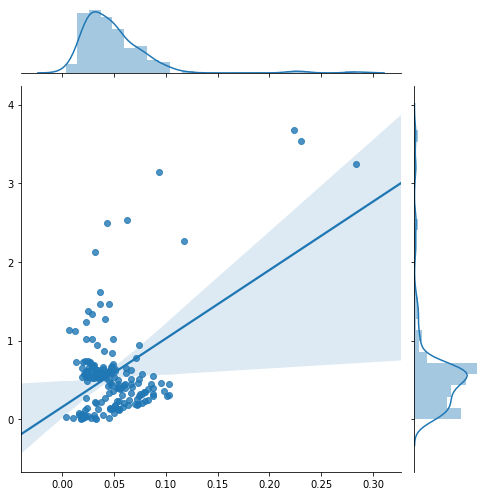

In [40]:
#Draw a joint reg plot of mortality rate and recovery rate

sns.jointplot(mortality_rate, recovery_rate , kind="reg", size=7)
plt.show()

## Let's store data of countries in a dictionary 

In [41]:
con_wise_confirm_cases = {}
con_wise_recovered_cases = {}
con_wise_death_cases = {}

for c in worst_countries.index:
    con_wise_confirm_cases[c] = confirmed_df[confirmed_df['Country/Region']==c].loc[:,dates].sum(axis = 0).values
    con_wise_death_cases[c] = deaths_df[deaths_df['Country/Region']==c].loc[:,dates].sum(axis = 0).values
    con_wise_recovered_cases[c] = recoveries_df[recoveries_df['Country/Region']==c].loc[:,dates].sum(axis = 0).values

con_wise_confirm_cases

{'US': array([      1,       1,       2,       2,       5,       5,       5,
              5,       5,       7,       8,       8,      11,      11,
             11,      11,      11,      11,      11,      11,      12,
             12,      13,      13,      13,      13,      13,      13,
             13,      13,      15,      15,      15,      15,      15,
             15,      16,      16,      24,      30,      53,      73,
            104,     174,     222,     337,     451,     519,     711,
           1109,    1561,    2157,    2870,    2968,    4360,    6141,
           8917,   14157,   19479,   25825,   33761,   43850,   54112,
          66055,   84091,  102276,  122069,  141205,  162707,  188724,
         214205,  244610,  276547,  309699,  337573,  367215,  397992,
         429686,  464442,  497943,  527969,  556522,  581813,  608878,
         637974,  669272,  701996,  730337,  756375,  783716,  809228,
         837422,  871617,  907908,  940829,  968518,  990999, 1015518,


In [42]:
con_wise_confirm_cases.keys()

dict_keys(['US', 'Brazil', 'Russia', 'India', 'Spain', 'Italy', 'Germany', 'Iran', 'Turkey', 'Peru', 'Chile', 'Mexico', 'Pakistan', 'Saudi Arabia', 'South Africa', 'Bangladesh', 'Belgium', 'Qatar', 'Colombia', 'Sweden', 'Ecuador', 'Belarus', 'Switzerland', 'Portugal', 'Egypt', 'United Arab Emirates', 'Singapore', 'Indonesia', 'Argentina', 'Ukraine', 'Kuwait', 'Ireland', 'Poland', 'Philippines', 'Israel', 'Romania', 'Austria', 'Iraq', 'Dominican Republic', 'Panama', 'Oman', 'Japan', 'Korea, South', 'Afghanistan', 'Kazakhstan', 'Bolivia', 'Bahrain', 'Nigeria', 'Armenia', 'Serbia'])

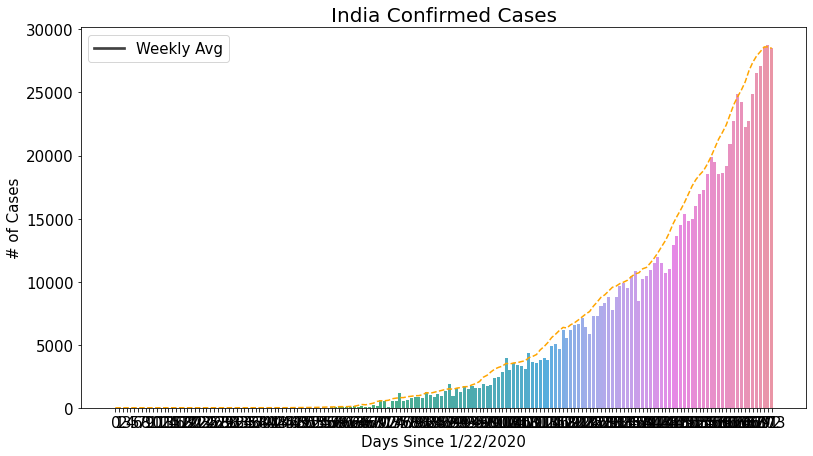

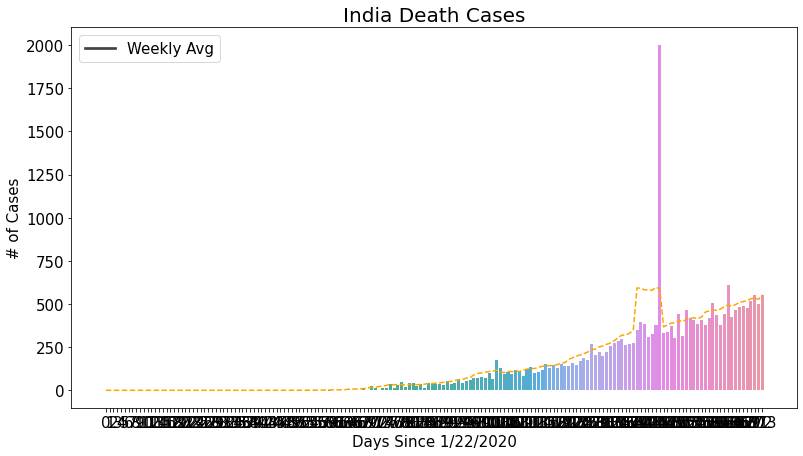

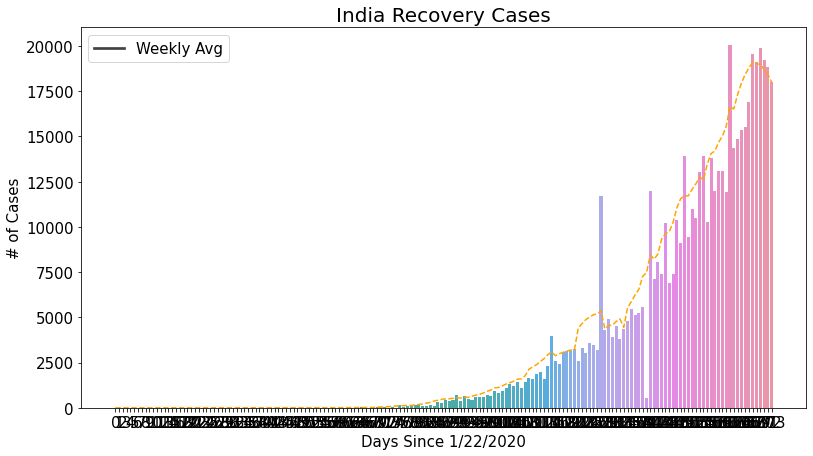

In [43]:
india_daily = daily_values(con_wise_confirm_cases['India'])
india_avg = weekly_average(india_daily)

india_daith_daily = daily_values(con_wise_death_cases['India'])
india_death_avg = weekly_average(india_daith_daily)

india_recovery_daily = daily_values(con_wise_recovered_cases['India'])
india_recovert_avg = weekly_average(india_recovery_daily)

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], india_daily)
plt.title('India Confirmed Cases', size=20)
plt.plot(days, india_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], india_daith_daily)
plt.title('India Death Cases', size=20)
plt.plot(days, india_death_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], india_recovery_daily)
plt.title('India Recovery Cases', size=20)
plt.plot(days, india_recovert_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

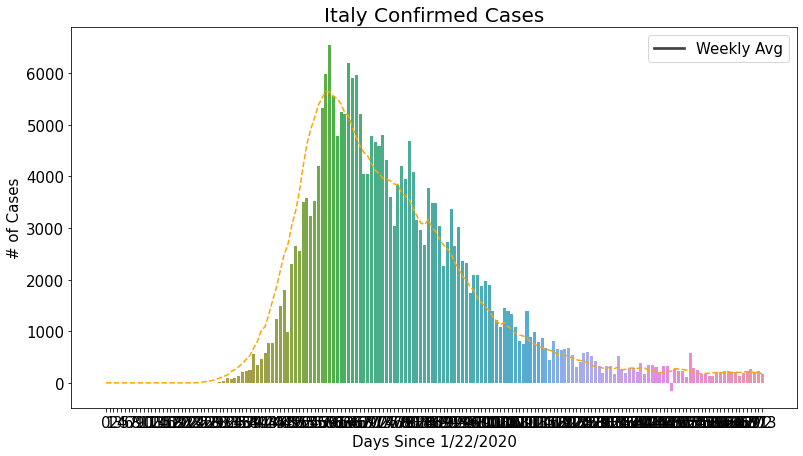

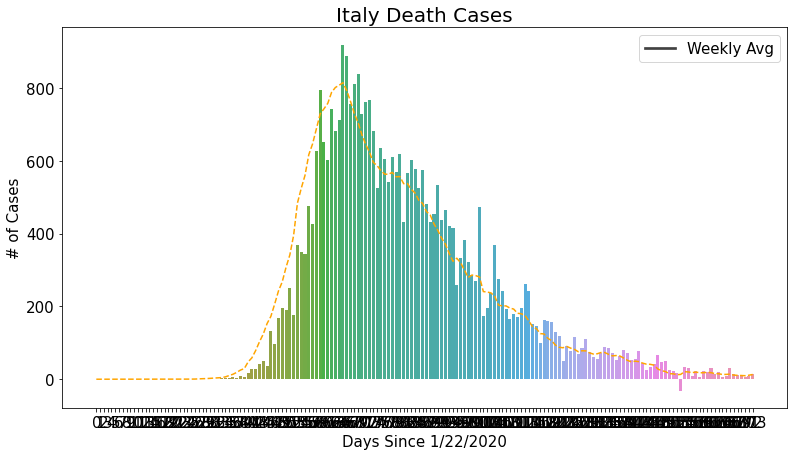

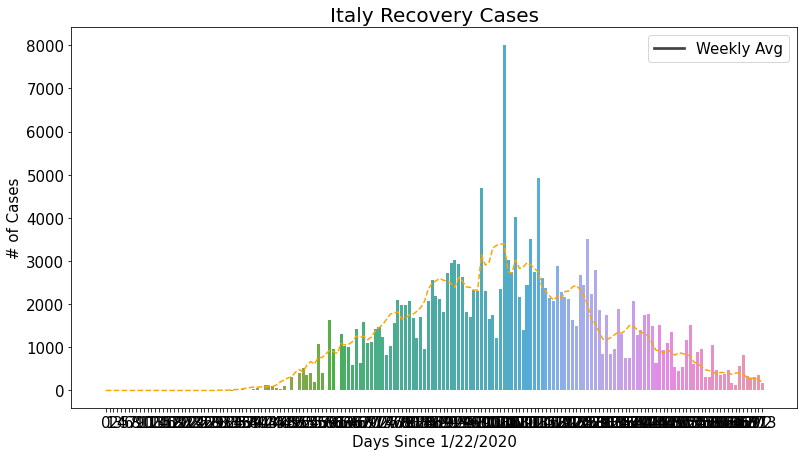

In [44]:
con_daily = daily_values(con_wise_confirm_cases['Italy'])
con_avg = weekly_average(con_daily)

con_daith_daily = daily_values(con_wise_death_cases['Italy'])
con_death_avg = weekly_average(con_daith_daily)

con_recovery_daily = daily_values(con_wise_recovered_cases['Italy'])
con_recovert_avg = weekly_average(con_recovery_daily)

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daily)
plt.title('Italy Confirmed Cases', size=20)
plt.plot(days, con_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daith_daily)
plt.title('Italy Death Cases', size=20)
plt.plot(days, con_death_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_recovery_daily)
plt.title('Italy Recovery Cases', size=20)
plt.plot(days, con_recovert_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

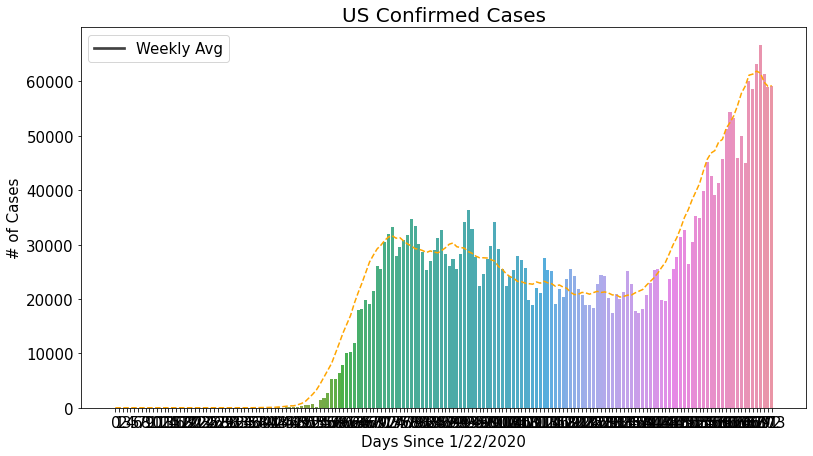

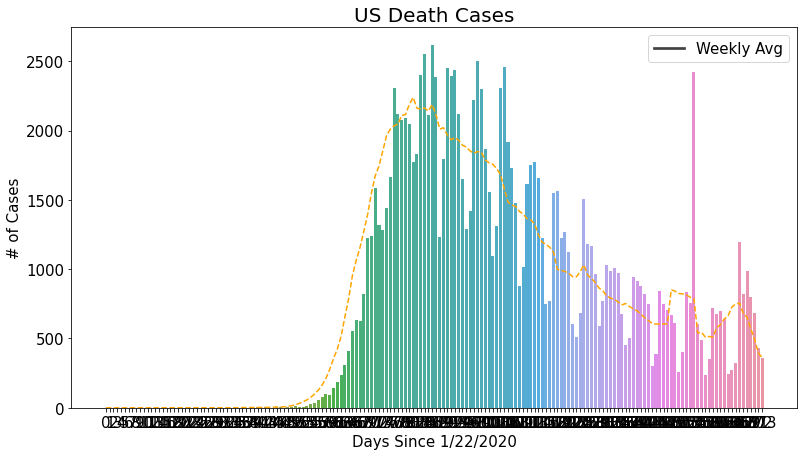

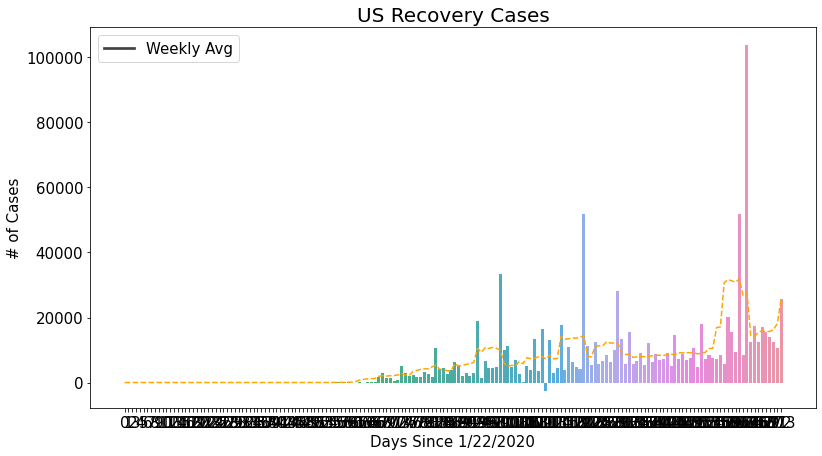

In [45]:
con_daily = daily_values(con_wise_confirm_cases['US'])
con_avg = weekly_average(con_daily)

con_daith_daily = daily_values(con_wise_death_cases['US'])
con_death_avg = weekly_average(con_daith_daily)

con_recovery_daily = daily_values(con_wise_recovered_cases['US'])
con_recovert_avg = weekly_average(con_recovery_daily)

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daily)
plt.title('US Confirmed Cases', size=20)
plt.plot(days, con_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daith_daily)
plt.title('US Death Cases', size=20)
plt.plot(days, con_death_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_recovery_daily)
plt.title('US Recovery Cases', size=20)
plt.plot(days, con_recovert_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [46]:
## Cannot use Area Plot with -ve values, so let's go with Line Plot

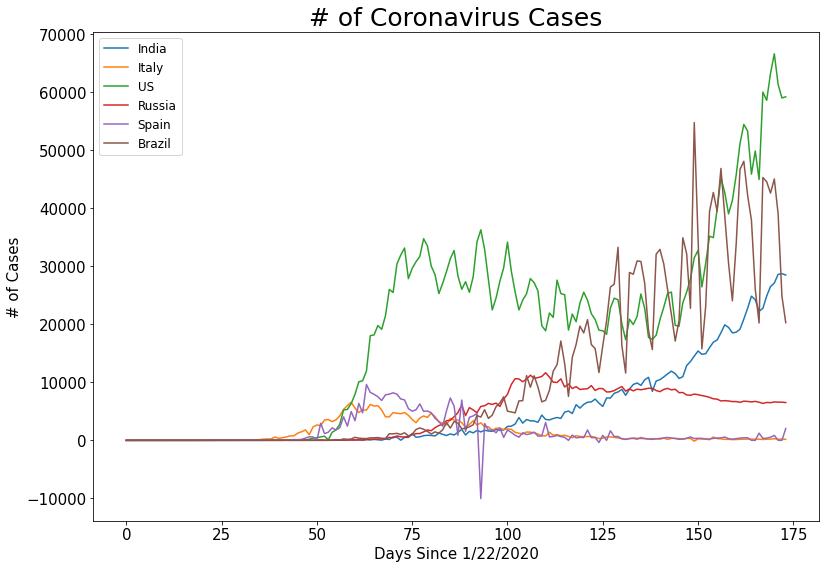

In [47]:
plt.figure(figsize=(13, 9))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['India']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Italy']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['US']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Russia']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Spain']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Brazil']))

plt.title('# of Coronavirus Cases', size=25)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['India', 'Italy', 'US', 'Russia', 'Spain','Brazil'], prop={'size': 12})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()


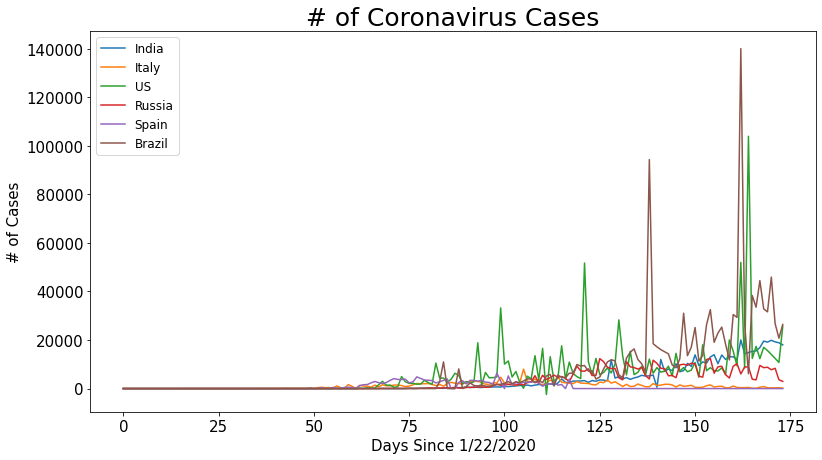

In [48]:
plt.figure(figsize=(13, 7))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['India']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Italy']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['US']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Russia']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Spain']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Brazil']))

plt.title('# of Coronavirus Cases', size=25)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['India', 'Italy', 'US', 'Russia', 'Spain','Brazil'], prop={'size': 12})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

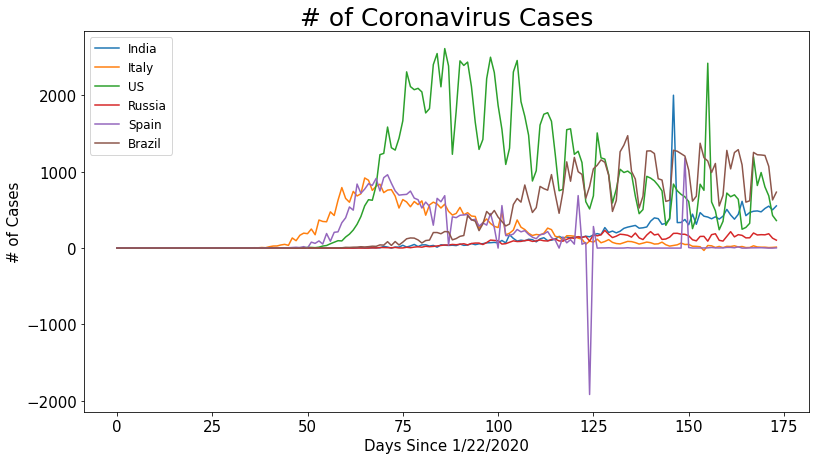

In [49]:
plt.figure(figsize=(13, 7))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['India']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Italy']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['US']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Russia']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Spain']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Brazil']))

plt.title('# of Coronavirus Cases', size=25)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['India', 'Italy', 'US', 'Russia', 'Spain','Brazil'], prop={'size': 12})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [50]:
latest_data_df.head() # Latest data has only 1 country, USA

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-07-13 04:43:16,32.3182,-86.9023,53587,1121,25783.0,26683.0,1,1092.901859,511506.0,6745.0,2.091925,84000001,USA,10432.117083,12.587008
1,Alaska,US,2020-07-13 04:43:16,61.3707,-152.4044,1479,17,615.0,847.0,2,202.174849,145475.0,NaN,1.149425,84000002,USA,19885.994710,NaN
2,American Samoa,US,2020-07-13 04:43:16,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,816.0,NaN,NaN,16,ASM,1466.544455,NaN
3,Arizona,US,2020-07-13 04:43:16,33.7298,-111.4312,122467,2237,14829.0,105401.0,4,1682.535535,696172.0,5795.0,1.826615,84000004,USA,9564.487807,4.731887
4,Arkansas,US,2020-07-13 04:43:16,34.9697,-92.3731,28367,321,21591.0,6455.0,5,939.988150,382402.0,1822.0,1.131597,84000005,USA,12671.532015,6.422956


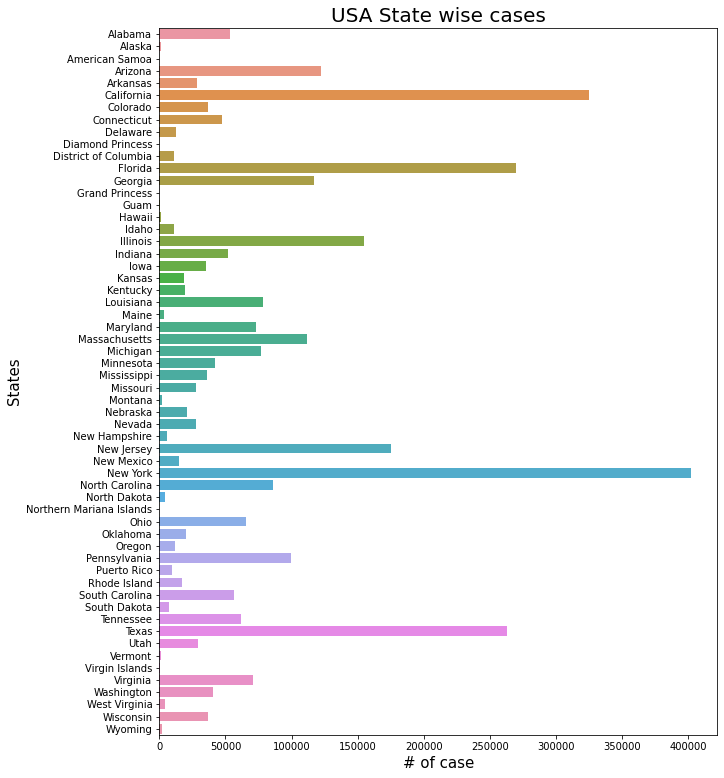

In [51]:
plt.figure(figsize=(10,13))
sns.barplot(x = latest_data_df['Confirmed'],y=latest_data_df['Province_State'])
plt.title('USA State wise cases', size=20)
plt.xlabel('# of case', size=15)
plt.ylabel('States', size=15)
plt.show()

**Worst hit state in US is NewYork, followed by California, Florida, and Texas**

In [52]:
x = latest_data_df['Confirmed'].sort_values(ascending=False)[:10]
y = []
for i in x.index:
    y.append(latest_data_df['Province_State'][i])
    
x = list(x)
temp = sum(latest_data_df['Confirmed'].sort_values(ascending=False)[10:])
x.append(temp)
y.append('Others')

Text(0.5, 1.0, '% of cases based on US states')

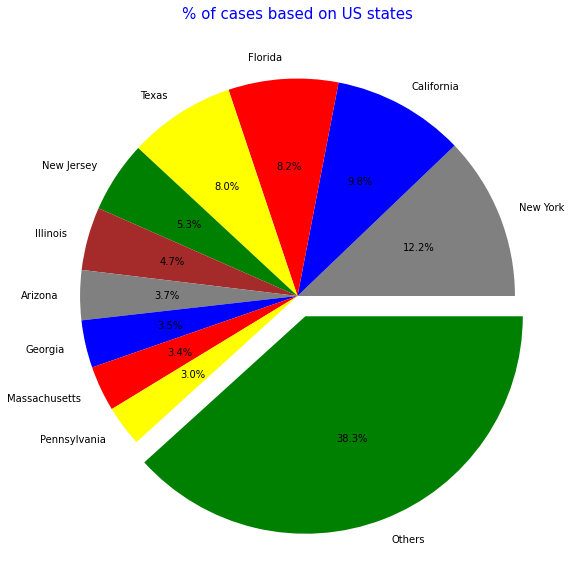

In [53]:
colors = ['grey','blue','red','yellow','green','brown']
explode = [0,0,0,0,0,0,0,0,0,0,0.1]

# visual
plt.figure(figsize = (10,10))
plt.pie(x, labels=y, explode = explode,colors=colors, autopct='%1.1f%%')
plt.title('% of cases based on US states',color = 'blue',fontsize = 15)

## We can see that Latest Data has only US as country, and CSSE data has no variable that can be used to do our predictions well except Independence_rate a proven by Pearson corr and Chi sq test

## But we can use our daily cases data to pretend a trend if any through Time Series Prediction

**We can use LSTM and XGBoost as our predictive Networks but the data is too small, i,e little over 150. Using such ensemble and large models would lead to bad results only, so let's try to do Regression on this. Let's try simple Linear Regression Since data is very much Linear**

In [54]:
total_cases_X = np.array(daily_values(total_cases)).reshape(-1, 1)
total_deaths_X = np.array(daily_values(total_deaths)).reshape(-1, 1)
total_recoveries_X = np.array(daily_values(total_recoveries)).reshape(-1, 1)

### I will do Time-Series Split later when we predict using TimeSeries currently I am using simple split. We could do some Feature Engineering and make some new feature but then anything I do will be baised because of cases in US in our data provided. I'll simply do some normal split and try if regression works

In [55]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days, total_cases_X, test_size=0.11, shuffle=False)
print("size of X_train = {} \nsize of X_test = {}".format(len(X_train_confirmed),len(X_test_confirmed)))

size of X_train = 154 
size of X_test = 20


In [56]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train_confirmed, y_train_confirmed)

[15:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [57]:
xg_pred = xgb_model.predict(X_test_confirmed)
print(mean_absolute_error(y_test_confirmed, xg_pred))

29003.525


MAE: 29003.525
MSE: 1240697070.649414


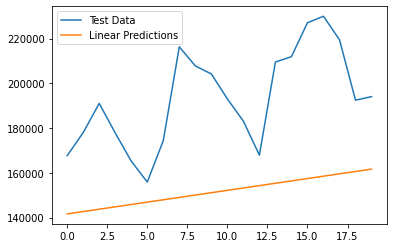

In [58]:
#Try Linear Regression

import numpy as np
from sklearn.linear_model import LinearRegression
Lreg = LinearRegression(normalize=True).fit(X_train_confirmed, y_train_confirmed)

# check against testing data
m_pred = Lreg.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(m_pred)
plt.legend(['Test Data', 'Linear Predictions'])
print('MAE:', mean_absolute_error(xg_pred, y_test_confirmed))
print('MSE:',mean_squared_error(xg_pred, y_test_confirmed))

MAE: 41678.732117829364
MSE: 2071657895.7594943


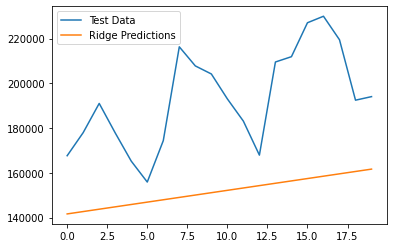

In [59]:
#Try Ridge Regression

from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0).fit(X_train_confirmed, y_train_confirmed)

# check against testing data
m_pred = reg.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(m_pred)
plt.legend(['Test Data', 'Ridge Predictions'])
print('MAE:', mean_absolute_error(m_pred, y_test_confirmed))
print('MSE:',mean_squared_error(m_pred, y_test_confirmed))

### Ridge Regression and Linear Regression both yield similar results.
#### Mostly Because of the lack of data availablity and the way we are predicting.

In [60]:
# We cannot use days as we are currently using, so let's change the approach

In [61]:
# Cross validation could help in understanding and fine tunning the model,
# let's use cross-validation this time to predict Confirmed Cases

A better alternative for cross validation on time series data (than K-fold CV) is Forward Chaining strategy.

In [62]:
# Let's create a formatted date column to do prediction
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(days)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%Y-%m-%d'))
future_forcast_dates

['2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-25',
 '2020-01-26',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-

In [63]:
time_df = pd.DataFrame({'date':future_forcast_dates,'Confirmed':daily_values(total_cases)})
time_df = time_df.sort_values('date')
time_df = time_df.groupby('date')['Confirmed'].sum().reset_index()
time_df = time_df.set_index('date')
time_df.index = pd.to_datetime(time_df.index)
time_df

,Confirmed
date,
2020-01-22,555
2020-01-23,99
2020-01-24,287
2020-01-25,493
2020-01-26,684
...,...
2020-07-09,227038
2020-07-10,229949
2020-07-11,219441


In [64]:
temp = time_df['Confirmed'].resample('D').mean()
temp

date
2020-01-22       555
2020-01-23        99
2020-01-24       287
2020-01-25       493
2020-01-26       684
               ...  
2020-07-09    227038
2020-07-10    229949
2020-07-11    219441
2020-07-12    192449
2020-07-13    194034
Freq: D, Name: Confirmed, Length: 174, dtype: int64

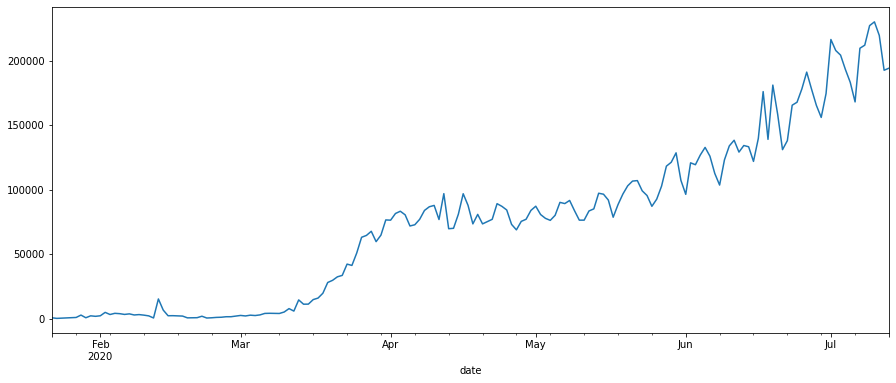

In [65]:
temp.plot(figsize=(15, 6))
plt.show()

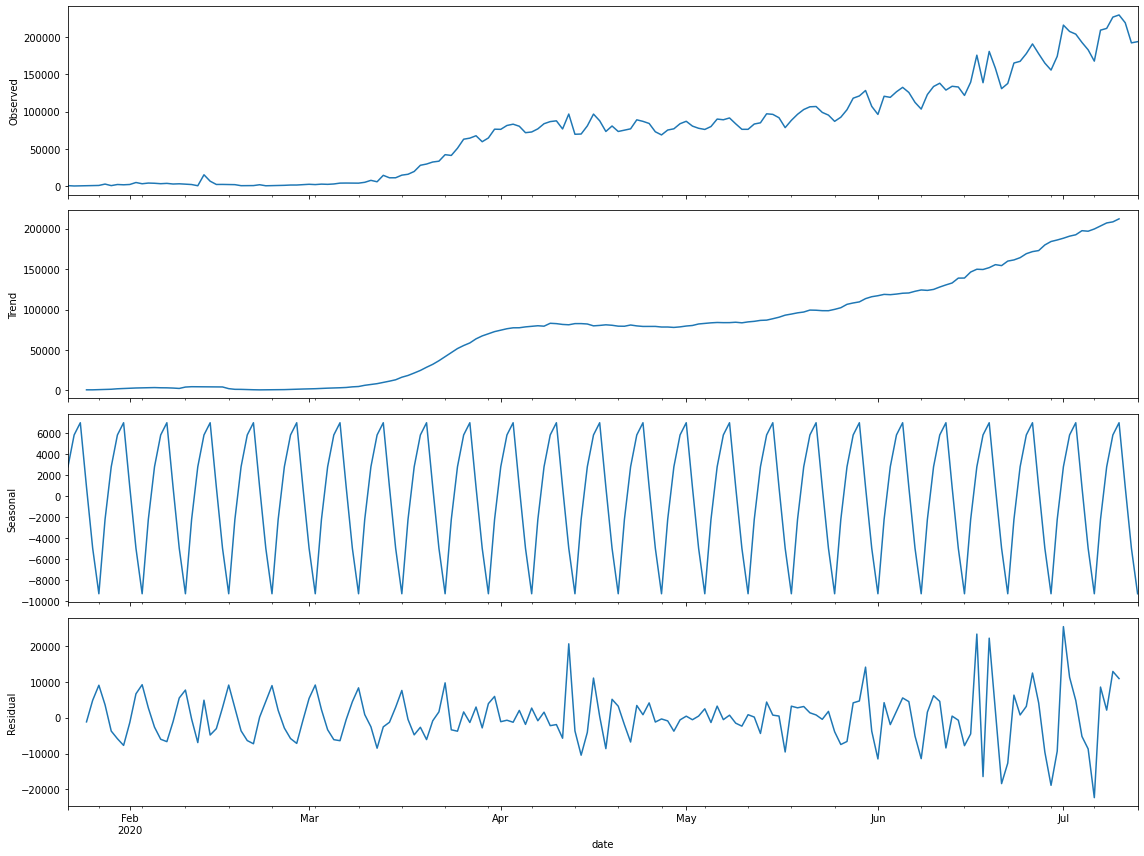

In [66]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from pylab import rcParams
import itertools

rcParams['figure.figsize'] = 16, 12

# LEt's use statsmodel api to get some visualization and pre-built models

decomposition = sm.tsa.seasonal_decompose(temp, model='additive')
fig = decomposition.plot()
plt.show()

**There for sure is some trend going on**

In [67]:
import sklearn.metrics as metrics

# Let's define a function to get all the metrics

def regression_results(y_true, y_pred):# Regression metrics
    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [68]:
# we will ad a yesterday column basedon which we will predict Confirmed cases
time_df.loc[:,'Yesterday'] = time_df.loc[:,'Confirmed'].shift()# inserting another column with day before yesterday's values.
time_df = time_df.dropna()
time_df

,Confirmed,Yesterday
date,,
2020-01-23,99,555.0
2020-01-24,287,99.0
2020-01-25,493,287.0
2020-01-26,684,493.0
2020-01-27,809,684.0
...,...,...
2020-07-09,227038,211878.0
2020-07-10,229949,227038.0
2020-07-11,219441,229949.0


In [69]:
X_train_confirmed = time_df[:'2020-06'].drop(['Confirmed'], axis = 1)
y_train_confirmed = time_df.loc[:'2020-06', 'Confirmed']

X_test_confirmed = time_df['2020-07':].drop(['Confirmed'], axis = 1)
y_test_confirmed = time_df.loc['2020-07':, 'Confirmed']

X_train_confirmed , y_train_confirmed

(            Yesterday
 date                 
 2020-01-23      555.0
 2020-01-24       99.0
 2020-01-25      287.0
 2020-01-26      493.0
 2020-01-27      684.0
 ...               ...
 2020-06-26   177959.0
 2020-06-27   191001.0
 2020-06-28   177814.0
 2020-06-29   165218.0
 2020-06-30   155869.0
 
 [160 rows x 1 columns], date
 2020-01-23        99
 2020-01-24       287
 2020-01-25       493
 2020-01-26       684
 2020-01-27       809
                ...  
 2020-06-26    191001
 2020-06-27    177814
 2020-06-28    165218
 2020-06-29    155869
 2020-06-30    174369
 Name: Confirmed, Length: 160, dtype: int64)

LR: -0.947865 (2.082442)
KNN: -3.330900 (6.564851)
RF: -5.326225 (17.026088)
SVR: -74.084342 (74.631233)


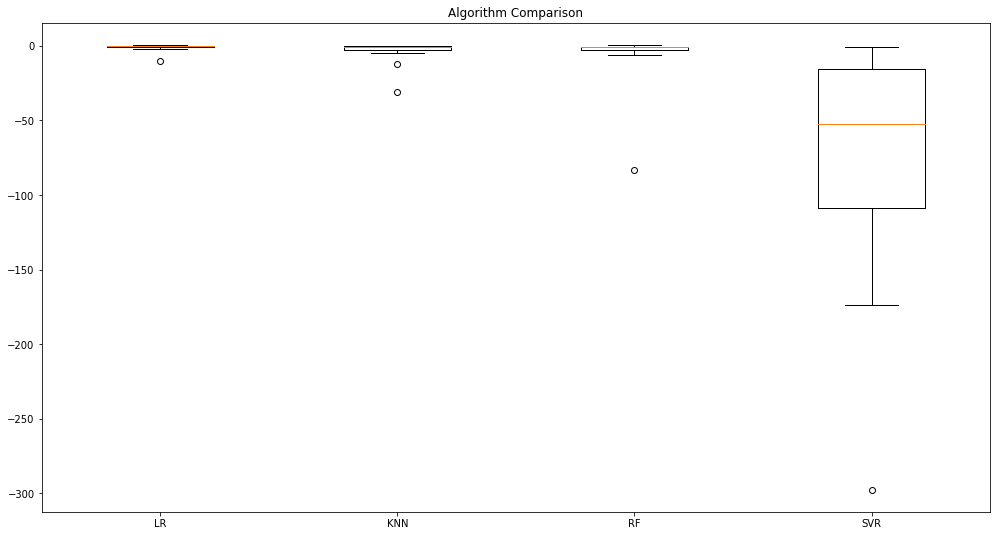

In [70]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
rcParams['figure.figsize'] = 17, 9
    
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear# Evaluate each model in turn
results = []
names = []

for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=22)
    
    cv_results = cross_val_score(model, X_train_confirmed, y_train_confirmed, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [71]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

param_search = { 
    'n_estimators': [25, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid = param_search, scoring = rmse_score)
gsearch.fit(X_train_confirmed, y_train_confirmed)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [72]:
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [73]:
y_true = y_test_confirmed.values
y_pred = best_model.predict(X_test_confirmed)

regression_results(y_true, y_pred)

explained_variance:  -0.0556
mean_squared_log_error:  0.0442
r2:  -4.5041
MAE:  36024.0394
MSE:  1605670553.3626
RMSE:  40070.8192


MAE: 36024.03936993561
MSE: 1605670553.3625972


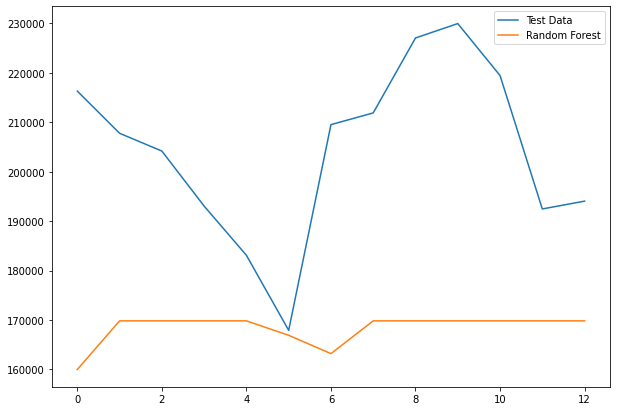

In [74]:
plt.figure(figsize=(10,7))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['Test Data', 'Random Forest'])
print('MAE:', mean_absolute_error(y_pred, y_test_confirmed))
print('MSE:',mean_squared_error(y_pred, y_test_confirmed))

In [75]:
# Results are better with RandomForestRegressor than were with our previous technique
# We can easily do the same with recoveries and deaths trends too :)

## Prediction of cases are improved by using TimeSeriesSplit() 
#### This was a small overview of my skills in the field. I am Comfortable with avanced techniques in Computer Vision and NLP.
#### Please visit my website wherein I am doing 100 Projects in Deep Learning.
---
### [AI Unquote](https://www.aiunquote.com)
***

<br>

**Thank you**

**Alaap Dhall**